<a href="https://colab.research.google.com/github/insooAI/My-Portfolio/blob/main/Satisfaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

# Satisfaction

In [ ]:
train = pd.read_csv('/content/drive/My Drive/데이터/3주차/satisfaction_train.csv', index_col=0)
test = pd.read_csv('/content/drive/My Drive/데이터/3주차/satisfaction_test.csv', index_col=0)

## EDA

In [ ]:
train.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
105527,Female,Loyal Customer,39,Business travel,Business,2725,5,5,2,5,4,4,5,4,4,4,4,4,4,4,73,65.0,satisfied
82617,Female,Loyal Customer,27,Business travel,Business,1634,3,3,3,3,3,3,3,3,3,4,4,2,3,3,39,37.0,dissatisfied
34069,Female,Loyal Customer,21,Personal Travel,Eco Plus,1341,4,4,0,1,1,0,1,1,4,1,3,5,4,1,0,0.0,satisfied
18636,Male,Loyal Customer,64,Personal Travel,Eco Plus,3794,2,5,2,4,2,1,1,5,3,3,5,1,4,1,570,567.0,dissatisfied
28693,Female,Loyal Customer,69,Personal Travel,Eco,1237,5,5,5,5,4,5,5,5,5,5,5,3,5,4,69,72.0,satisfied


## Data Preprocessing

In [ ]:
# 오분류율 함수
def misc_rate(test,pred):
    return 1 - accuracy_score(test,pred)

In [ ]:
alldata = pd.concat([train,test])

In [ ]:
def num_to_str(data):
    colname = [col for col in data.columns[:-1]]
    nunique = [len(data[col].unique()) for col in data.columns[:-1]]
    zipp = dict(zip(colname, nunique))   
    
    # dummy 화 
    for col in data.columns[:-1]:
        if zipp[col] <=6:
            data[col] = data[col].apply(lambda x: str(x))
    # data = pd.get_dummies(data)
    
    return data

In [ ]:
# 'satisfaction' in alldata.columns[:-1]

### 문자를 숫자로 맵핑

In [ ]:
alldata.Gender = alldata['Gender'].apply(lambda x: 1 if x == 'Female' else 0)
alldata['Customer Type'] = alldata['Customer Type'].apply(lambda x: 1 if x == 'Loyal Customer' else 0)
alldata['Type of Travel'] = alldata['Type of Travel'].apply(lambda x: 1 if x == 'Business travel' else 0)
alldata.Class = alldata['Class'].apply(lambda x: 1 if x == 'Business' else 2 if x == 'Eco Plus' else 3)
alldata.satisfaction = alldata['satisfaction'].apply(lambda x: 1 if x == 'satisfied' else 0)

### str 함수 적용

In [ ]:
alldata_ = num_to_str(alldata)

In [ ]:
alldata_.head()   

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
105527,1,1,39,1,1,2725,5,5,2,5,4,4,5,4,4,4,4,4,4,4,73,65.0,1
82617,1,1,27,1,1,1634,3,3,3,3,3,3,3,3,3,4,4,2,3,3,39,37.0,0
34069,1,1,21,0,2,1341,4,4,0,1,1,0,1,1,4,1,3,5,4,1,0,0.0,1
18636,0,1,64,0,2,3794,2,5,2,4,2,1,1,5,3,3,5,1,4,1,570,567.0,0
28693,1,1,69,0,3,1237,5,5,5,5,4,5,5,5,5,5,5,3,5,4,69,72.0,1


In [ ]:
info(alldata_)

,colname,dtype,unique_value,unique_count
0,Gender,object,"[1, 0]",2
1,Customer Type,object,"[1, 0]",2
2,Age,int64,"[39, 27, 21, 64, 69, 36, 29, 62, 22, 58, 37, 5...",75
3,Type of Travel,object,"[1, 0]",2
4,Class,object,"[1, 2, 3]",3
5,Flight Distance,int64,"[2725, 1634, 1341, 3794, 1237, 2370, 3055, 904...",5002
6,Seat comfort,object,"[5, 3, 4, 2, 0, 1]",6
7,Departure/Arrival time convenient,object,"[5, 3, 4, 2, 1, 0]",6
8,Food and drink,object,"[2, 3, 0, 5, 4, 1]",6
9,Gate location,object,"[5, 3, 1, 4, 2]",5


### train, test split

In [ ]:
# train2 = alldata_.iloc[train.index]
# test2 = alldata_.iloc[test.index]

train2 = alldata_[:len(train)]
test2 = alldata_[len(train):]

train2_x = train2.drop(['satisfaction'],1)
train2_y = train2['satisfaction']

test2_x = test2.drop(['satisfaction'],1)
test2_y = test2['satisfaction']

In [ ]:
sum(train2.index != train.index)

0

## Modeling

In [ ]:
# 튜닝 전
## default : n_estimator: 100 /  min_samples_leaf: 1 / max_samples_split: 2 / max_features : 루트(p) / max_depth = None (트리의 최대깊이)
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 0) 
rf.fit(train2_x, train2_y)
y_pred = rf.predict(test2_x)
misc_rate(test2_y,y_pred)

0.04448219939763687

In [ ]:
# 그리드 서치 튜닝 후
params = {
    'n_estimators':[100,300],
    'max_depth': [6,8,10],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8,16,20]
}

rf = RandomForestClassifier(random_state = 0, n_jobs=-1)
grid_cv = GridSearchCV(rf, param_grid=params, cv=3, n_jobs=-1)
grid_cv.fit(train2_x, train2_y)

print(grid_cv.best_params_)
print(grid_cv.best_score_)

{'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
0.9255705483611023


In [ ]:
rf = RandomForestClassifier(random_state = 0, max_depth=10, min_samples_leaf=8, min_samples_split=8, n_estimators=100)
rf.fit(train2_x, train2_y)
y_pred = rf.predict(test2_x)
misc_rate(test2_y,y_pred)

0.07205189589929728

## 결론 3 :
- 1. 범주를 숫자로 맵핑 
- 2. 카테고리의 성격을 띠는 숫자형 변수를 문자형변수로 바꿈
- 3. 랜덤포레스트 모델
- 1) 튜닝 전 : 0.04448219939763687
- 2) 튜닝 후 : 0.07205189589929728



#### 변수 중요도 시각화

In [ ]:
rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:

col_importances_values = rf.feature_importances_
# col_importances = pd.Series()

In [ ]:
col_importances_values # 리스트 형태

array([0.02856752, 0.04826124, 0.00944638, 0.02650897, 0.03904587,
       0.01559436, 0.1467954 , 0.01427858, 0.03701218, 0.00815089,
       0.01221525, 0.25224085, 0.08160976, 0.08227758, 0.0457226 ,
       0.04728011, 0.02020674, 0.01851059, 0.01896692, 0.03811943,
       0.00360751, 0.00558127])

In [ ]:
col_importances = pd.Series(col_importances_values, index = train2_x.columns)
top20_imp = col_importances.sort_values(ascending = False)[:20]

In [ ]:
# col_importances
top20_imp

Inflight entertainment               0.252241
Seat comfort                         0.146795
Ease of Online booking               0.082278
Online support                       0.081610
Customer Type                        0.048261
Leg room service                     0.047280
On-board service                     0.045723
Class                                0.039046
Online boarding                      0.038119
Food and drink                       0.037012
Gender                               0.028568
Type of Travel                       0.026509
Baggage handling                     0.020207
Cleanliness                          0.018967
Checkin service                      0.018511
Flight Distance                      0.015594
Departure/Arrival time convenient    0.014279
Inflight wifi service                0.012215
Age                                  0.009446
Gate location                        0.008151
dtype: float64

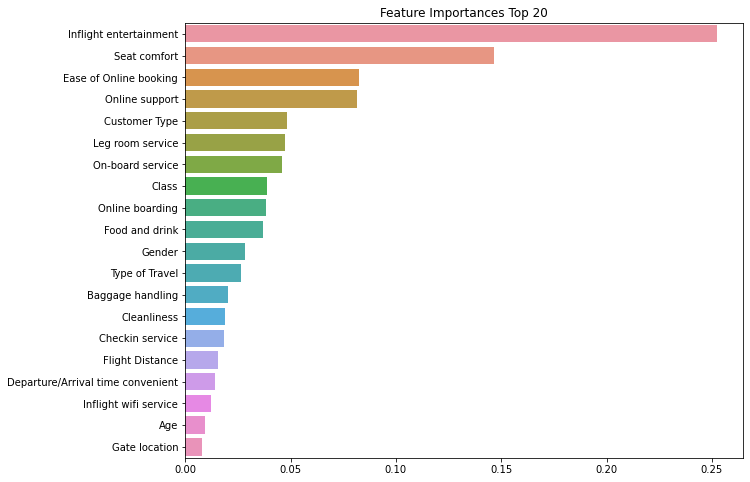

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Feature Importances Top 20')
sns.barplot(x = top20_imp, y= top20_imp.index)
